In [11]:
from timeit import default_timer as timer
t_start = timer()

import xarray as xr
from dea_tools.temporal import xr_phenology
import numpy as np
import warnings, os
warnings.filterwarnings("ignore")
from pathlib import Path
from glob import glob

In [12]:
# bucketname = 'sanca'
# version = '0.2'
# desc = 'cloud masked, gap filled with < 25 days'
# satellite = 'Landsat'

# ec2 = False

# save = False
# outds = False
# hist = False

In [13]:
farmgroupid = '9a151331-1b50-4804-b416-c217d45d6ac6'
vi = 'LAI'
source = f'{vi}_mgap_90_w_7_v2.nc'

remove_temp = True

suffix = 'safra'
start = '06-20'
end = '03-20'

# all years = 0 or chose year as list of int
years = 0

# the metrics
basic_pheno_stats = [
    "SOS","vSOS","POS", "vPOS",
    "EOS", "vEOS","Trough", "LOS","AOS",
    "ROG","ROS"]
method_sos = "first"
method_eos = "last"

In [14]:
# Open VI file
file = f'/mnt/geodata/Clientes/0FARMS/{farmgroupid}/results/{source}'
print(f'source file for {vi} is {file}')
df = xr.open_dataset(file)
folderout = f'/mnt/geodata/Clientes/0FARMS/{farmgroupid}/results/Phenology/'
Path(f'{folderout}').mkdir( parents = True, exist_ok = True)

source file for LAI is /mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/results/LAI_mgap_90_w_7_v2.nc


In [15]:
nextyear = 0
if years == 0:
    print('o-o check yeaars \n')
    if int(end[:2]) > int(start[:2]):
        print('o-o end > start: season start and finish in the same year \n    typically safrinha or northern hemisphere')#and int(end[:2]) < int(str(df.time.values[-1]).split('T')[0][5:7]):
        if int(end[:2]) > int(str(df.time.values[-1]).split('T')[0][5:7]):
            print('!!! you are asking for more than you have \n error: end > data.end')
        else:
            print('! you are good to go')
            years = np.unique(df.time.dt.year)
            print('> selected years:', years)
    else: 
        print('o-o you are looking at the tropics and southern hemisphere, \n    since your season go to the next year (+1)')
        nextyear = 1
        years = np.unique(df.time.dt.year)[:-1]
        print('> selected years:', years, ' (+1)')
else:
    print('o-o your customized choice')
    years = sorted(years)
    if int(end[:2]) < int(start[:2]):
        print(f' end < start : {end[:2]} < {start[:2]}')
        nextyear = 1
        
        print('> selected years: ', years, ' (+1)')
    else:
        
        
        print('> selected years:', years)

o-o check yeaars 

o-o you are looking at the tropics and southern hemisphere, 
    since your season go to the next year (+1)
> selected years: [2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]  (+1)


In [16]:
dates = []
for year in years:
    da = df['LAI'].sel(time=slice(f'{year}-{start}',f'{year+nextyear}-{end}'))
    da = da.compute()
    stats = xr_phenology( da, method_sos=method_sos, method_eos=method_eos, stats=basic_pheno_stats,
                    verbose=False )
    # add results to dict
    #datelabel = f'{year}-06-20'
    date = np.datetime64(f'{year}-{end}')
    dates.append(date)
    stats = stats.expand_dims(dim='time')
    stats.to_netcdf(f'{folderout}/phenology_{year}_{suffix}.nc')
    del da, stats


In [17]:
files = sorted(glob(f'{folderout}/phenology*{suffix}.nc'))
print(files)

DF = xr.open_mfdataset(files, concat_dim='time', combine='nested')
DF = DF.assign_coords({'time':dates})
di, df = str(DF.time.values[0])[:4] , str(DF.time.values[-1])[:4]
print(di,df)

DF.to_netcdf(f'{folderout}/Phenology_{di}-{df}_{suffix}.nc')

['/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/results/Phenology/phenology_2013_safra.nc', '/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/results/Phenology/phenology_2014_safra.nc', '/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/results/Phenology/phenology_2015_safra.nc', '/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/results/Phenology/phenology_2016_safra.nc', '/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/results/Phenology/phenology_2017_safra.nc', '/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/results/Phenology/phenology_2018_safra.nc', '/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/results/Phenology/phenology_2019_safra.nc', '/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/results/Phenology/phenology_2020_safra.nc', '/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/results/Phenology/phenology_2021_safra.nc', 

In [18]:
DF = xr.open_mfdataset(files, concat_dim='time', combine='nested')
DF = DF.assign_coords({'time':dates})
di, df = str(DF.time.values[0])[:4] , str(DF.time.values[-1])[:4]
DF.to_netcdf(f'{folderout}/Phenology_{di}-{df}_{suffix}.nc')
if remove_temp == True:
    os.system(f'rm {folderout}/phe*')
    print('!! temporary phenology* files removed')
t_end = timer()
print('\n total execution time: \n ',t_end - t_start, ' seconds')

!! temporary phenology* files removed

 total execution time: 
  2.1882179020003605  seconds


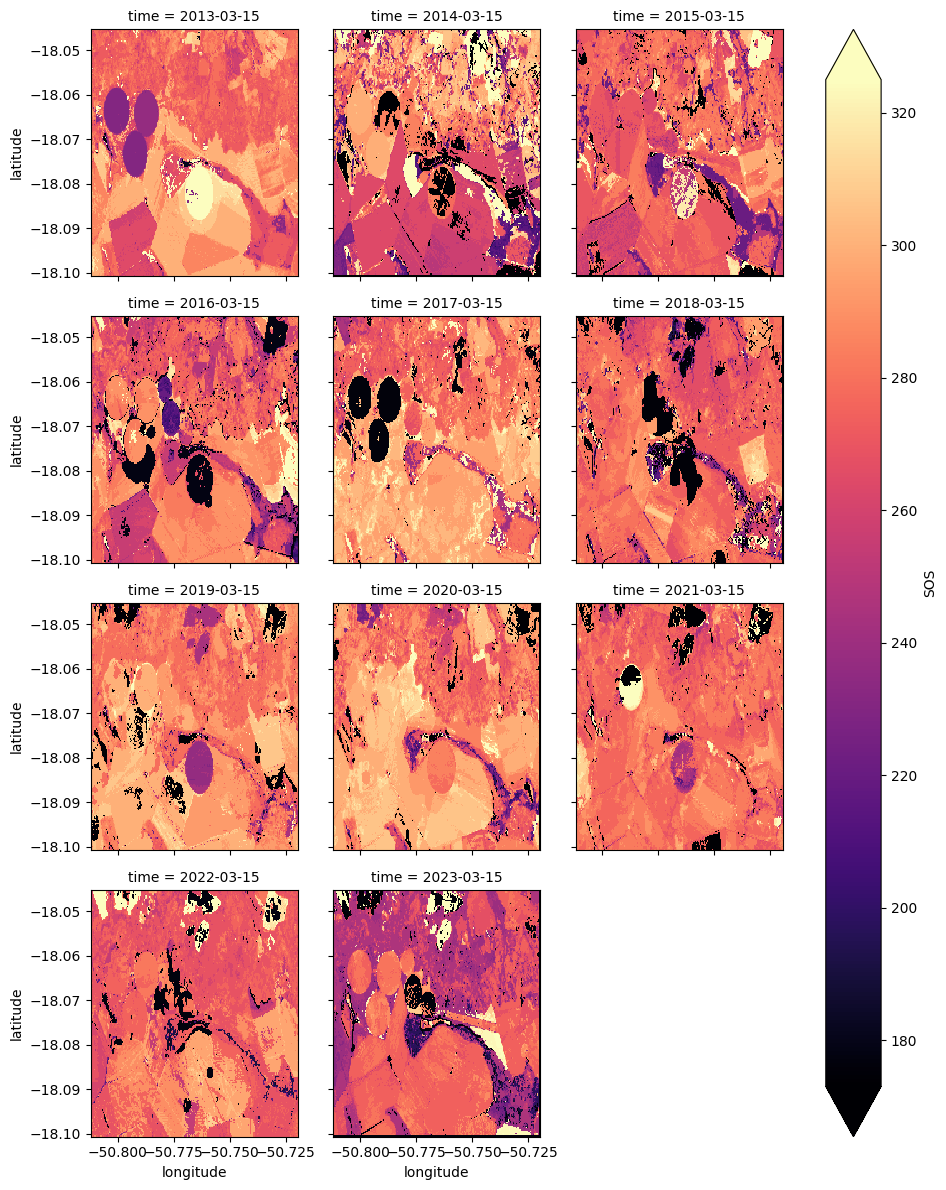

In [19]:
DF['SOS'].plot(col = 'time', col_wrap=3, robust=True, cmap = 'magma')

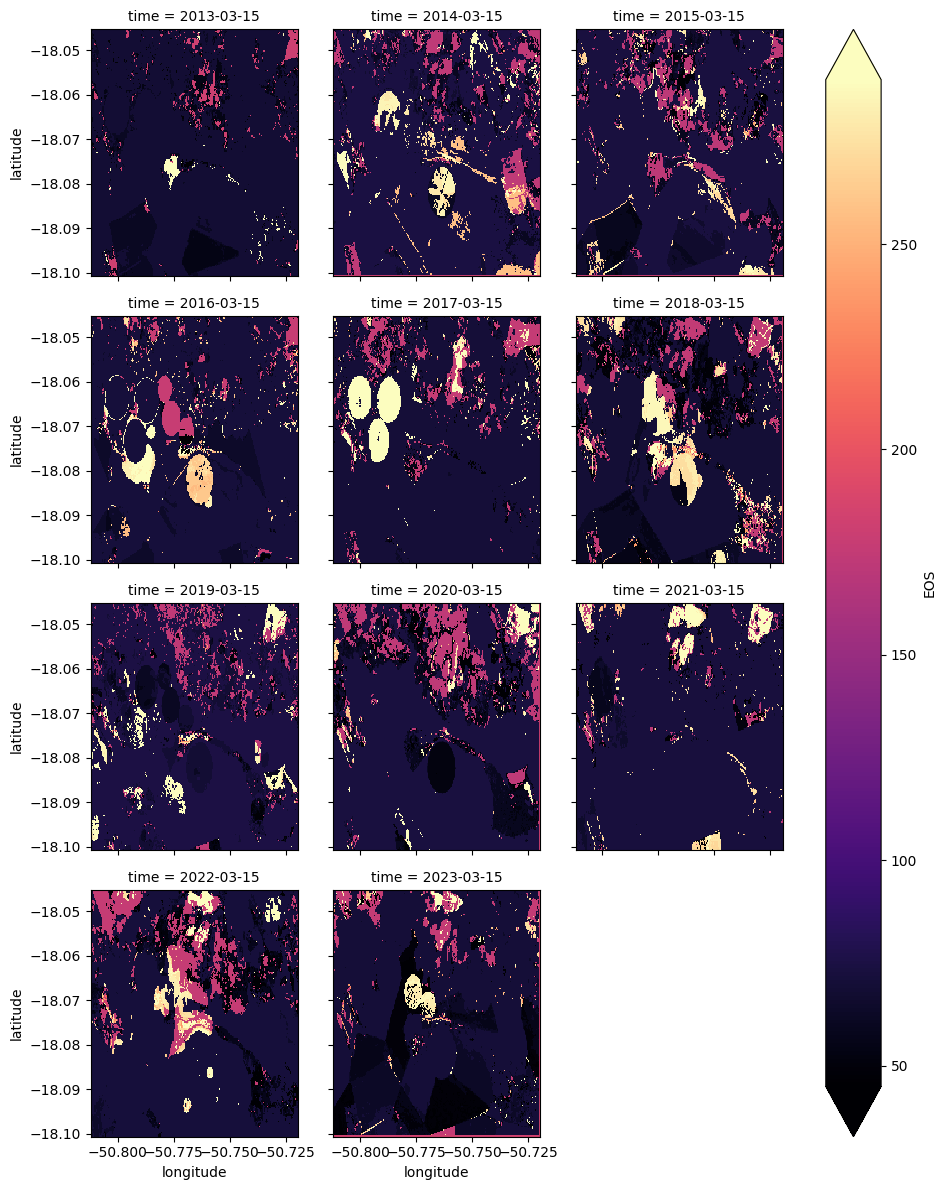

In [20]:
DF['EOS'].plot(col = 'time', col_wrap=3, robust=True, cmap = 'magma')